In [ ]:
!curl https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv --output ./airline-passengers.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2180  100  2180    0     0   5547      0 --:--:-- --:--:-- --:--:--  5532


# Сегодня мы познакомимся с Рекуррентными Нейронными Сетями (RNN)
Познакомимся с VanillaRNN, LSTM и GRU, узнаем как ими пользоваться для решения задач на временном ряде и в чем между ними разница. 

Простейшая RNN (VanillaRNN) - нейронная сеть, которая последовательно обрабатывает элементы временного ряда используя некое состояние с предыдущего шага в текущем. 
![rnn](https://miro.medium.com/max/1400/0*c1L9jjcsASagk_Hu.png "Simple RNN")

Простейшая RNN клетка состояит из следующих шагов: 

* Вычисление скрытого состояния $a^{<t>}=tanh(W_{aa}a^{<t−1>}+W_{ax}x^{<t>}+b_a)$
* Использую новое скрытое состояние, вычисление предсказания $y^{<t>} = W_{ya}a^{<t>}$ для задачи востановления регрессии или $y^{<t>} = Softmax(W_{ya}a^{<t>})$ для классификации


LSTM, GRU или любой другой тип реккурентной сети будет отличаться от VanillaRNN только структурой клетки. 

GRU - более простая архитектура, чем LSTM, не смотря на то, что появилась она значительно позже LSTM. 

![gru](https://i.stack.imgur.com/oJ39p.png "GRU Cell")

![lstm](https://www.researchgate.net/profile/Savvas-Varsamopoulos/publication/329362532/figure/fig5/AS:699592479870977@1543807253596/Structure-of-the-LSTM-cell-and-equations-that-describe-the-gates-of-an-LSTM-cell.jpg "LSTM Cell")

Сегодня мы рассмотрим проблему предсказания числа пассажиров авиалиний. Нужно, зная только дату, предсказать число пассажирова в этот день. Для этого у нас есть исторические данные с 1949 по 1960 годы. 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

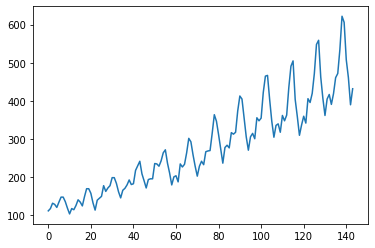

In [ ]:
df = pd.read_csv('airline-passengers.csv', usecols=[1])
plt.plot(df)
plt.show()

Видно, что в данныех есть переодичность и явный тренд. Попробуем научить простую RNN модель предсказывать целевую переменную.

Как мы уже знаем из лекций, нейронные сети чувствительны к порядкам данных, так-что нам необходимо будет нормировать даннные. И сразу разобьем датасет на тренировочную и тестовую части. Сети будут доступны наблюдения за последнии 30 дней. 


In [ ]:
dataset = df.values
dataset = dataset.astype('float32')

scaler = Pipeline([
    # ("Логарифмирование", FunctionTransformer(func=np.log, inverse_func=np.exp),),
    ("Масштабирование", MinMaxScaler(feature_range=(0, 1)),),
    ])

dataset = scaler.fit_transform(dataset)

In [ ]:
dataset.shape

(144, 1)

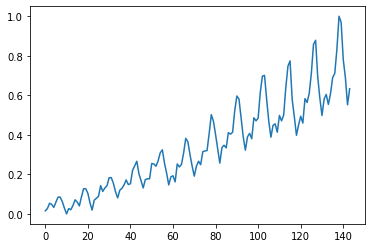

In [ ]:
plt.plot(dataset)

In [ ]:
train_size = int(len(dataset) * 0.6)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [ ]:
train.shape, test.shape

((86, 1), (58, 1))

In [ ]:
def create_dataset(dataset, look_back=1):
    '''
    dataset - [N,1] np.ndarray
    look_back - number of points from the past used to predict the next point
    '''
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back-1), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

trainX, trainY = create_dataset(train, 30)
testX, testY = create_dataset(test, 30)

# [samples, time step, feature]
trainX = np.reshape(trainX, (*trainX.shape, 1))
testX = np.reshape(testX, (*testX.shape, 1))

trainX.shape, trainY.shape

((55, 29, 1), (55,))

In [ ]:
testX.shape, testY.shape

((27, 29, 1), (27,))

Начнем с простейшей RNN и посмотрим, какие результаты мы получим. 

Использовать сегодня будем Keras.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, GRU, LSTM

In [ ]:
rnn_layer = SimpleRNN(8, input_shape=(29, 1))
rnn_layer

CPU times: user 6.09 s, sys: 225 ms, total: 6.32 s
Wall time: 6.54 s


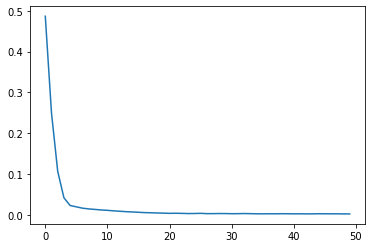

In [ ]:
%%time

model = Sequential()
model.add(SimpleRNN(8, input_shape=(29, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=50, batch_size=4, verbose=0)

plt.plot(history.history['loss'])

In [ ]:
%%time
test_preds = model.predict(testX)

CPU times: user 308 ms, sys: 6.97 ms, total: 315 ms
Wall time: 403 ms


In [ ]:
test_preds.shape

(27, 1)

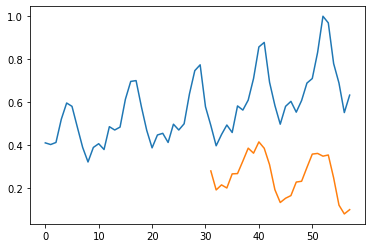

In [ ]:
test_timesteps = np.arange(len(test))
predicted_timesteps = test_timesteps[-len(test_preds):]
plt.plot(test_timesteps, test)
plt.plot(predicted_timesteps, test_preds)
plt.show()

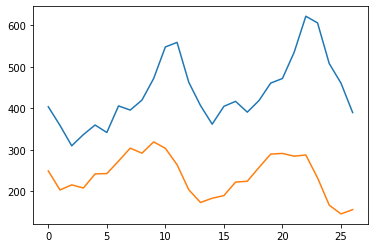

In [ ]:
test_preds_descaled = scaler.inverse_transform(test_preds)
testY_descaled = scaler.inverse_transform([testY])

plt.plot(testY_descaled[0])
plt.plot(test_preds_descaled)
plt.show()

MSE 46138.40784051614


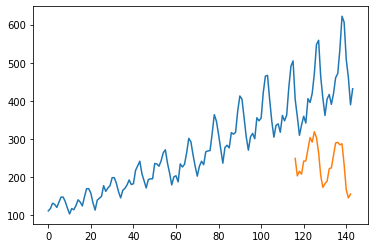

In [ ]:
def eval_model(model, testX, testY):
    '''
    model - keras RNN model
    testX - np.ndarray [bs, dt, 1]
    '''
    test_preds = model.predict(testX)

    test_preds = scaler.inverse_transform(test_preds)
    testY_descaled = scaler.inverse_transform([testY])

    print(f'MSE {mean_squared_error(testY_descaled[0], test_preds[:,0])}')

    test_preds_plot = np.empty_like(dataset)
    test_preds_plot[:, :] = np.nan # plt.plot won't visualize them
    test_preds_plot[len(trainX)+(30*2)+1:len(dataset)-1, :] = test_preds
    # plot baseline and predictions
    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(test_preds_plot)

eval_model(model, testX, testY)

Vanilla RNN клетка с 8 скрытыми состояниями показывает сносные результаты. Причем обучается такая сеть очень быстро в силу своей простоты. 
Но в ней слабо учитываются старые данные, в силу таких вещей, как "забывание" уже старой инфомации. С этим нам могут помочь так называемые "ворота", которые есть в GRU и LSTM.

# LSTM

In [ ]:
%%time
model = Sequential()
model.add(LSTM(8, input_shape=(29, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=50, batch_size=4, verbose=0)

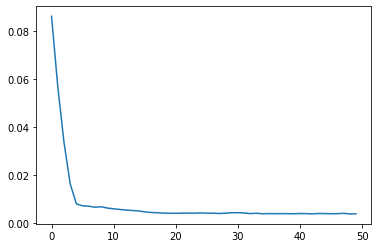

In [ ]:
model = Sequential()
model.add(LSTM(8, input_shape=(29, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=50, batch_size=4, verbose=0)
plt.plot(history.history['loss'])

In [ ]:
testX.shape

(27, 29, 1)

In [ ]:
trainX.shape

(55, 29, 1)

In [ ]:
%%time
test_preds = model.predict(testX)

CPU times: user 737 ms, sys: 9.82 ms, total: 747 ms
Wall time: 934 ms


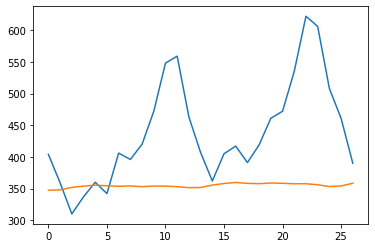

In [ ]:
test_preds_descaled = scaler.inverse_transform(test_preds)
testY_descaled = scaler.inverse_transform([testY])

plt.plot(testY_descaled[0])
plt.plot(test_preds_descaled)
plt.show()

MSE 13261.537598013978


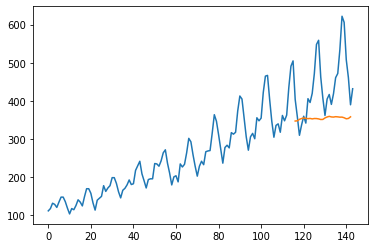

In [ ]:
eval_model(model, testX, testY)

# GRU

In [ ]:
%%time
model = Sequential()
model.add(GRU(8, input_shape=(29, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=50, batch_size=4, verbose=0)

CPU times: user 14.9 s, sys: 824 ms, total: 15.8 s
Wall time: 11.2 s


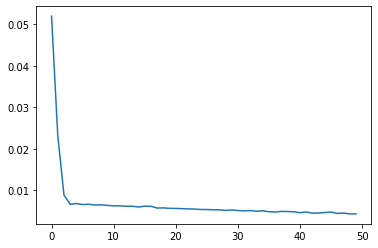

In [ ]:
plt.plot(history.history['loss'])


In [ ]:
%%time 
test_preds = model.predict(testX)

CPU times: user 415 ms, sys: 11.1 ms, total: 426 ms
Wall time: 424 ms


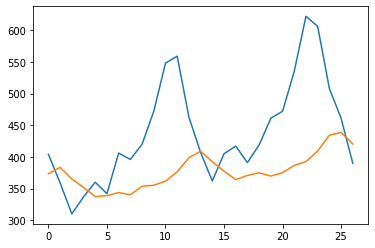

In [ ]:
test_preds_descaled = scaler.inverse_transform(test_preds)
testY_descaled = scaler.inverse_transform([testY])

plt.plot(testY_descaled[0])
plt.plot(test_preds_descaled)
plt.show()

MSE 9161.455104116121


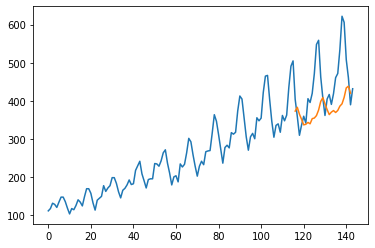

In [ ]:
eval_model(model, testX, testY)